# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [1]:
!pip install pycrf
!pip install sklearn-crfsuite

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

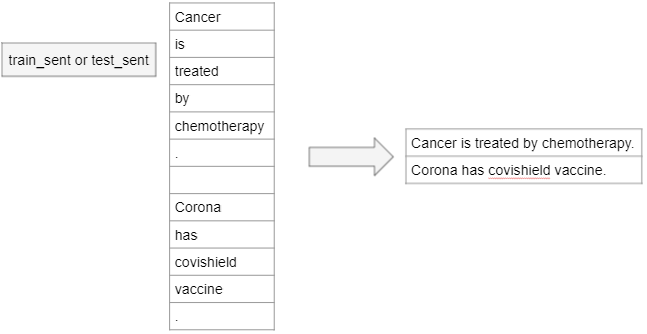

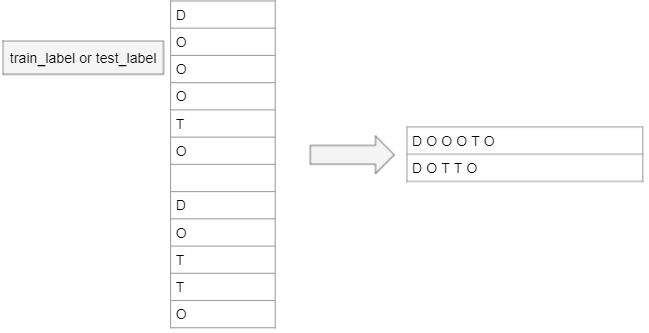

In [2]:
def parse_file(file_name):
    file=open(file_name,'r')
    data=file.readlines() 
    file.close()
    L=[];sent=[] 
    for line in data:
        if line == '\n': 
            sent.append(" ".join(L))
            L=[]
        else: 
            L.append(line.rstrip('\n'))
    return sent

In [3]:
# train set sentences
train_set=parse_file('train_sent')
train_set[1:15]

['The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )',
 'Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )',
 "The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )",
 "Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )",
 'Cesarean rates at tertiary care hospitals should be compared with rates at community hospitals only after correcting for dissimilar patient groups or gestational age',
 'In the third trimester , the amniotic fluid index ( AFI ) may be affected by maternal fluid status',
 'We hypothesize that as temperature increases there would be a concomitant decrease in AFI',
 "From June 11 to August 16 , 1993 , during a period of unusual high heat , 42 women with singleton pregnancies between 27 and 40 wee

In [4]:
# parse train labels
train_label=parse_file('train_label')
train_label[1:15]

['O O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O',
 'O O O O O O O D D O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O']

In [5]:
# parse test sentences
test_set=parse_file('test_sent')
test_set[:10]

['Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )',
 'As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration',
 'The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period',
 'There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )',
 'Fluctuations in ambient temperature are inversely correlated to changes in AFI',
 'This study tested the hypothesis that to reduce the rate of macrosomic infants in gestational diabetes cases , good glycemic control should be initiated before 34 completed gestational weeks',
 "In the `` early '' and `` late '' groups , mean gestational age at the beginning 

In [6]:
# parse test labels
test_label=parse_file('test_label')
test_label[:10]

['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O D D',
 'O O O O O O O O O O O O O O O O O O O D D O O O O O O O O']

In [7]:
# Combining trains and test sentences for Exploratory data analysis
all_sent = train_set+test_set
len(all_sent)

3655

In [8]:
#Observe 3655 total sentences in the corpus
all_labels=train_label+test_label
len(all_labels)

3655

In [9]:
#Similarly, observe 3655 total labels in the entire given corpus
# Creating a dataframe out of the given sentences and labels
import pandas as pd
df=pd.DataFrame(list(zip(all_sent,all_labels)), columns=['sentences','labels'])
df.head()


,sentences,labels
0,All live births > or = 23 weeks at the Univers...,O O O O O O O O O O O O O O O O O O O O O O O ...
1,The total cesarean rate was 14.4 % ( 344 of 23...,O O O O O O O O O O O O O O O O O O O O O O O O O
2,Abnormal presentation was the most common indi...,O O O O O O O O O O O O O O O
3,The `` corrected '' cesarean rate ( maternal-f...,O O O O O O O O O O O O O O O O O O O O O O O ...
4,Arrest of dilation was the most common indicat...,O O O O O O O O O O O O O O O O O O O O O O


In [10]:
# Creating new columns which is the total number of O tags, D tags and T tags in a sentence/document
import re
df['O_label']=df.labels.apply(lambda x: len(re.findall('O',x))) # Get total number of O labels in the given sentence
df['D_label']=df.labels.apply(lambda x: len(re.findall('D',x))) # Get total number of D labels in the given sentence
df['T_label']=df.labels.apply(lambda x: len(re.findall('T',x))) # Get total number of T labels in the given sentence
df.tail(10) 

,sentences,labels,O_label,D_label,T_label
3645,"Dry powdered formoterol , twice a day versus a...",T T T O O O O O T T O O O O O O O O O D D,14,2,5
3646,Celecoxib for arthritis,T O D,1,1,1
3647,Poliomyelitis prevention : revised recommendat...,D O O O O O O O O O O O D T,11,2,1
3648,Brimonidine tartrate 0.2 % twice daily vs timo...,T T O O O O O T O O O O O O O O D O,14,1,3
3649,Epoetin : a pharmacoeconomic review of its use...,T O O O O O O O O D D D O O O O O O O,15,3,1
3650,Reduction of vasoreactivity and thrombogenicit...,O O D O D O T T O O O T T,7,2,4
3651,Effects of ultrasound energy on total peripher...,O O T T O D D D D O O O O O O O,10,4,2
3652,High-dose chemotherapy with autologous stem-ce...,T T T T T T O D D D,1,3,6
3653,`` Tandem '' high-dose chemoradiotherapy with ...,T T T T T T T T T O O O O O O O O D D,8,2,9
3654,Intravenous immune globulin for recurrent spon...,T T T O D D D,1,3,3


### EDA

In [11]:
df.describe()

,O_label,D_label,T_label
count,3655.000000,3655.000000,3655.000000
mean,15.269494,1.337620,1.045417
std,12.396386,2.109442,2.377397
min,0.000000,0.000000,0.000000
25%,6.000000,0.000000,0.000000
50%,12.000000,0.000000,0.000000
75%,21.000000,2.000000,1.000000
max,125.000000,34.000000,30.000000


In [12]:
df.shape

(3655, 5)

In [13]:
df[df.T_label>10]

,sentences,labels,O_label,D_label,T_label
165,"INTERPRETATION : Low , fixed-dose warfarin ( 1...",O O O O O T T T T T T T T T T T T T T T T O O ...,21,2,18
443,The posterior capsule and anterior vitreous we...,O O O O O O O O O O O O O O O O O O O O O O O ...,51,0,13
852,The treatment of diabetes 2 by the classic ora...,O O O D D O O T T T T T T T T T O O O T T T O T,9,2,13
1015,"Hyperbaric oxygen , whole-body X irradiation ,...",T T T T T T T T T T T O D D D,1,3,11
1534,Testicular sperm retrieval by percutaneous fin...,T T T T T T T T T O O T T T T T T O O O D D,5,2,15
2025,"intravenous injection of pb2-as , as a complex...",T T T T T T T T T T T T T T O O O O O O O O O ...,25,3,14
2037,only the combination of a cell wall-active ant...,O O T T T T T T T T T T T T T T T T T T T T T ...,21,9,30
2040,d-penicillamine ( 2-amino-3-mercapto-3-methylb...,T T T T T T T T T T T O O O O O O O O O O D D ...,18,22,11
2048,< TO_SEE > the standard care for patients with...,O O O O O O O O O D D D O T T T T O O T O O O ...,45,8,13
2051,results : we have performed 60 carinal resecti...,O O O O O O T T O D D O O T T T O D D D D D D ...,18,17,13


In [14]:
df.T_label.sum()

3821

In [15]:
df.O_label.sum()

55810

In [16]:
df.D_label.sum()

4889

In [17]:
df[(df.T_label==0)&(df.D_label==0)]

,sentences,labels,O_label,D_label,T_label
0,All live births > or = 23 weeks at the Univers...,O O O O O O O O O O O O O O O O O O O O O O O ...,45,0,0
1,The total cesarean rate was 14.4 % ( 344 of 23...,O O O O O O O O O O O O O O O O O O O O O O O O O,25,0,0
2,Abnormal presentation was the most common indi...,O O O O O O O O O O O O O O O,15,0,0
3,The `` corrected '' cesarean rate ( maternal-f...,O O O O O O O O O O O O O O O O O O O O O O O ...,38,0,0
4,Arrest of dilation was the most common indicat...,O O O O O O O O O O O O O O O O O O O O O O,22,0,0
...,...,...,...,...,...
3410,Relatives in the resuscitation room : their po...,O O O O O O O O O O,10,0,0
3412,Subcutaneous autologous ovarian transplantatio...,O O O O O O O O O O,10,0,0
3417,Adolescent pregnancy and sexual abuse,O O O O O,5,0,0
3418,Still hard to know how large the benefits will...,O O O O O O O O O O O,11,0,0


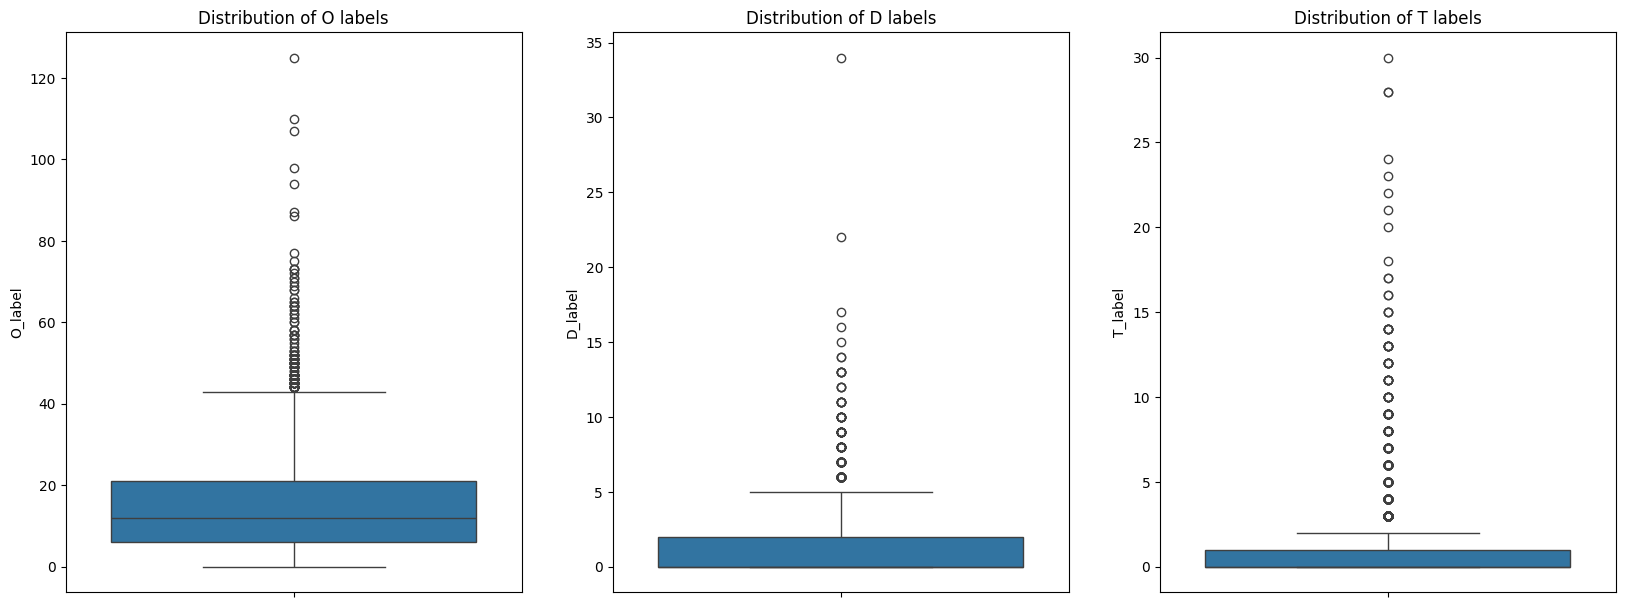

In [18]:
#total sentences has only O (Others) tags.
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


plt.figure(figsize=(20,16))
plt.subplot(2,3,1)
plt.title('Distribution of O labels')
sns.boxplot(df.O_label)
plt.subplot(2,3,2)
plt.title('Distribution of D labels')
sns.boxplot(df.D_label)
plt.subplot(2,3,3)
plt.title('Distribution of T labels')
sns.boxplot(df.T_label)
plt.show()

### During the EDA we can observe that per sentence, the distribution of the O label is above 120 in some sentences while its overall range of its values lie around 0 to 40.
### We also observe that there are comparatively few sentences that has D labels and even lesser of T labels.
### This observation can also be verifed in the describe function of the labels.

#### Count the number of sentences in the processed train and test dataset

In [19]:
print('Number of sentences in the train set: ',len(train_set))
print('Number of sentences in the test set: ',len(test_set))

Number of sentences in the train set:  2599
Number of sentences in the test set:  1056


#### Count the number of lines of labels in the processed train and test dataset

In [20]:
print('Number of labels in the train set: ',len(train_label))
print('Number of labels in the test set: ',len(test_label))

Number of labels in the train set:  2599
Number of labels in the test set:  1056


### Concept Identification
#### We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging.
### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [21]:
noun_or_propn=[] # initialize empty list
for review in all_sent: #looping through all sentences i.e. train and test sentences
    doc=model(review) # applying the NLP model on the sentence
    for token in doc: # Looping through the tokens created by the model
        if token.pos_=='NOUN' or token.pos_=='PROPN': # Checking if the pos_ tag is 'NOUN' or 'PROPN' 
            noun_or_propn.append(token.lemma_.lower()) # add to the list

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [22]:
pd.Series(noun_or_propn).value_counts().head(25)

patient         568
treatment       316
%               247
study           236
cancer          226
cell            203
therapy         182
effect          181
disease         170
group           145
case            132
result          121
lung            120
gene            111
year            105
rate            103
chemotherapy     91
use              91
trial            90
woman            89
conclusion       89
analysis         86
protein          82
response         81
risk             78
Name: count, dtype: int64

In [26]:
dict_of_words=pd.Series(noun_or_propn).value_counts().to_dict()

In [27]:
len(noun_or_propn)

24376

#### As we can see we have 24,326 words found that has parts of speech (PoS) tag of nouns or proper nouns from our model

## Defining features for CRF





In [28]:
# Let's define the features to get the feature value for one word.
def getFeaturesForOneWord(sentence, pos):
  word=sentence[pos]
  for token in model(word):
    word_pos_tag=token.pos_
  features=[
    'word.postag='+word_pos_tag, # f1 is the PoS tag of the word
    'word.lower='+word.lower(), # f2 is input word is in lower case
    'word[-3:]='+word[-3:], # Last three characters
    'word[-2:]='+word[-2:], # Last two characters
    'word.isupper=%s' % word.isupper(), # is the word in all upper case
    'word.isdigit=%s' % word.isdigit(), # is the word a number
    'words.startsWithCapital=%s' %word[0].isupper() # is the word starting with capital letter
  ]
  if pos>0:
    prev_word=sentence[pos-1]
    for token in model(prev_word):
      prev_word_pos_tag=token.pos_
    features.extend([
      'prev_word.postag='+prev_word_pos_tag, # previous word PoS tag
      'prev_word.lower=' + prev_word.lower(), # previous word in lower case
      'prev_word.isupper=%s' % prev_word.isupper(), # is previous word in upper case
      'prev_word.isdigit=%s' % prev_word.isdigit(), # is previous word a number
      'prev_words.startsWithCapital=%s' % prev_word[0].isupper() # is previous word starting with capital letter
    ])
  else:
    features.append('BEG') # Beginning of sentence
  if (pos == len(sentence)-1):
    features.append('END') # End of sentence
  return features

## Getting the features

### Write a code/function to get the features for a sentence

In [29]:
# Write a code to get features for a sentence.
def getFeaturesForOneSentence(sentence):
  sentence_list = sentence.split()
  return [getFeaturesForOneWord(sentence_list, pos) for pos in range(len(sentence_list))]

### Write a code/function to get the labels of a sentence

In [30]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
  return labels.split()

In [31]:
# Checking the workings of our feature on an example sentence from the trains set 
example_sentence = train_set[5] # Choosing 6th sentence
print(example_sentence) # Printing the entire sentence for reference

example_features = getFeaturesForOneSentence(example_sentence)
example_features[5] # Choosing the 6th word

Cesarean rates at tertiary care hospitals should be compared with rates at community hospitals only after correcting for dissimilar patient groups or gestational age


['word.postag=NOUN',
 'word.lower=hospitals',
 'word[-3:]=als',
 'word[-2:]=ls',
 'word.isupper=False',
 'word.isdigit=False',
 'words.startsWithCapital=False',
 'prev_word.postag=VERB',
 'prev_word.lower=care',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_words.startsWithCapital=False']

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [32]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_set]
Y_train = [getLabelsInListForOneSentence(labels) for labels in train_label]

### Define the labels as the target variable for test and the train dataset

In [33]:
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_set]
Y_test = [getLabelsInListForOneSentence(labels) for labels in test_label]

## Build the CRF Model

In [34]:
# Build the CRF model.
crf=sklearn_crfsuite.CRF(max_iterations=100)
crf.fit(X_train, Y_train)

CRF(max_iterations=100)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [35]:
Y_pred=crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [36]:
metrics.flat_f1_score(Y_test, Y_pred, average='weighted')

0.9097277438445563

In [37]:
# Testing a sample prediction against actual values
# Print the orginal labels and predicted labels for the sentence  in test data, which is at index value 1001
id = 1001
print("Sentence:",test_set[id])
print("Orig Labels:", Y_test[id])
print("Pred Labels:", Y_pred[id])

Sentence: An active-control trial of lamotrigine monotherapy for partial seizures
Orig Labels: ['O', 'O', 'O', 'O', 'T', 'T', 'O', 'D', 'D']
Pred Labels: ['O', 'O', 'O', 'O', 'T', 'T', 'O', 'D', 'D']


##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

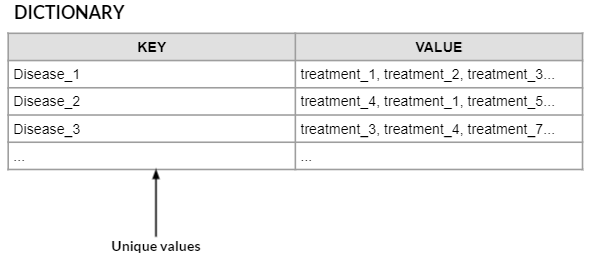

In [38]:
# Creating dictionary out of the predicted labels from our model
dict={}
for count, labels in enumerate(Y_pred): # we are taking the Y-pred labels and count will have the record ID
    temp="".join(labels) # removing the spaces between the lablels
    #print(count, temp)
    totalD=len(re.findall('D',temp)) # find number of 'D' in the sentence
    totalT=len(re.findall('T',temp)) # find number of 'T' in the sentence
    if totalD>0 and totalT>0: # this means that the sentence has disease and treatment
        indexD=[];indexT=[];start_from=0 # Initializing variables used
        for i in range(totalD):
            foundat=temp.find('D',start_from) # search for 'D' from start_from in the labels
            indexD.append(foundat) # put the foundat index in a list called indexD
            start_from=foundat+1 # re-initialize start_from from the next word
        start_from=0 # initialize the same variable for 'T' labels now
        for i in range(totalT):
            foundat=temp.find('T',start_from) # search for 'T' from start_from in the labels
            indexT.append(foundat) # put the foundat index in a list called indexT
            start_from=foundat+1 # re-initialize start_from from the next word
        disease='' # Initialize the string disease with empty string
        for i in indexD: # Looping through the indexes where 'D' is located
            disease=disease+test_set[count].split()[i] # we are taking i-th word of the count which is index of sentence
            if i+1 not in indexD: # Check condition if the next word is also in the list
                disease=disease+', ' # this will be executed for a new disease
            else:
                disease=disease+' ' # this will be executed for continuation of disease name
        treatment='' # Initialize the string treatment with empty string
        for i in indexT: # Looping through the indexes where 'D' is located
            treatment=treatment+test_set[count].split()[i] # we are taking i-th word of the count which is index of sentence
            if i+1 not in indexT: # Check condition if the next word is also in the list
                treatment=treatment+', ' # this will be executed for a new treatment
            else:
                treatment=treatment+' ' # this will be executed for continuation of treatment
        # finally entering the disease and treatment in the dictionary after removing the last comma and space character
        dict[disease.rstrip(', ')]=treatment.rstrip(', ') 
            
dict

{'nonimmune hydrops fetalis': 'Trisomy',
 'hereditary retinoblastoma': 'radiotherapy',
 'epilepsy': 'Methylphenidate',
 'unstable angina or non-Q-wave myocardial infarction': 'roxithromycin',
 'coronary-artery disease': 'Antichlamydial antibiotics',
 'primary pulmonary hypertension ( PPH )': 'fenfluramines',
 'cellulitis': 'G-CSF therapy, intravenous antibiotic treatment',
 'foot infection': 'G-CSF treatment',
 "early Parkinson 's disease": 'Ropinirole monotherapy',
 'sore throat': 'Antibiotics',
 "abdominal tuberculosis, Crohn 's disease": 'steroids',
 'treating stress urinary incontinence': 'surgical procedures',
 'female stress urinary incontinence': 'surgical treatment',
 'stress urinary incontinence': 'therapy',
 'preeclampsia ( proteinuric hypertension )': 'intrauterine insemination with donor sperm versus intrauterine insemination',
 'intra-abdominal injury': 'senior surgery',
 'severe acquired hyperammonemia, cancer': 'organ transplantation and chemotherapy',
 'major pulmonary 

In [39]:
# Creating dataframe out of the dictionary of disease and treatment
df1=pd.DataFrame(dict.items(),columns=['disease','treatment'])
df1.head()

,disease,treatment
0,nonimmune hydrops fetalis,Trisomy
1,hereditary retinoblastoma,radiotherapy
2,epilepsy,Methylphenidate
3,unstable angina or non-Q-wave myocardial infar...,roxithromycin
4,coronary-artery disease,Antichlamydial antibiotics


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [40]:
dict['hereditary retinoblastoma']

'radiotherapy'

### Here we can conclude that the treatment for 'heriditary retinoblastoma' is 'radiotherapy'